# Project 3 - Part 3 Pre-processing and Modelling
by: Nah Wei Jie

---

## Table of Contents
This project is broken down into 3 different parts, each with it's accompanying notebook.

**Part 1**
- Web scraping  

**Part 2** 

- Exploratory Data Analysis
- Data Cleaning
- Visualizations  

**Part 3**
- Pre-processing
- Model Fit and Testing
- Model Iteration
- Model Evaluation
    

---

## Library Imports

In [1]:
# Standard imports
import pandas as pd # Version 1.2.4
import numpy as np # Version 1.20.1
import time
import random
from collections import Counter

# Set pandas to display a maximum of 400 characters in the column
pd.options.display.max_colwidth = 200

# Datetime imports
from datetime import datetime
from dateutil import tz

# Visualization imports
import seaborn as sns # Version 0.11.1
import matplotlib.pyplot as plt # Version 3.3.4

# Matplotlib settings
small = 12
medium = 15
large = 20

plt.rc('font', size=small)          # controls default text sizes
plt.rc('axes', titlesize=small)     # fontsize of the axes title
plt.rc('axes', labelsize=medium)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=small)    # fontsize of the tick labels
plt.rc('ytick', labelsize=small)    # fontsize of the tick labels
plt.rc('legend', fontsize=small)    # legend fontsize
plt.rc('figure', titlesize=large)  # fontsize of the figure title

In [2]:
# NLP imports
import regex as re # Version 2.5.93
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
import spacy # Version 3.2.3
sp = spacy.load('en_core_web_sm') 

# Modelling Imports
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, plot_confusion_matrix,ConfusionMatrixDisplay, roc_auc_score, accuracy_score, plot_roc_curve

# Ignore warnings
import warnings
def ignore_warn(*args,**kwargs):
    pass
warnings.warn=ignore_warn

## Function Definitions

In [3]:
## NLP Functions

#Function to process a post, remove stopwords and lemmatize using spacy
def post_to_words_spacy(raw_post):
    # Function to convert a raw post to a string of words
    # The input is a single string and 
    # the output is a single string
    
    # 1. Create spacy object
    letters_only = re.sub("[^a-zA-Z]", " ", raw_post)
    sentence = sp(letters_only.lower())

    # 2. Remove non-letters and spaces,split into tokens
    words = [w for w in sentence if not w.is_punct | w.is_space | w.like_num]
    
    # 3. Lemmatize and remove stopwords using tokens 
    meaningful_words = [w.lemma_ for w in words if w.orth_ not in stops]
    
    # 4. Join the words back into one string separated by space, 
    # and return the result.
    return(" ".join(meaningful_words))


In [4]:
## Modelling Functions

# Function to run given data through pipeline with given vectorizer, models and their respective parameters
# and return the best parameters and their corresponding scores using selected models
def model_tuning(v_name,vectorizer,m_name,model,pipe_params,X_train,y_train,X_val,y_val):
    pipe = Pipeline([
    (v_name,vectorizer),
    (m_name,model)])
    
    gs_model = GridSearchCV(pipe,pipe_params,cv=10)
    gs_model.fit(X_train,y_train)
    
    model_name = v_name + "_" + m_name
    best_score = round(gs_model.best_score_,3)
    train_score = round(gs_model.score(X_train,y_train),3)
    test_score = round(gs_model.score(X_val,y_val),3)
    
    print(f'For {v_name}, {m_name}:')
    print(f'Best score: {best_score}')
    print(f'Train score: {train_score}')
    print(f'Test score: {test_score}')
    print(f'Best parameters: {gs_model.best_params_}')
    print("")
    
    return gs_model, [model_name, best_score, train_score, test_score]

# Function to use given model and test data to get predictions and get various scores and plot relevant visuals from scores
def model_eval(model,X_test,y_test):
    predictions = model.predict(X_test)
    tn, fp, fn, tp = confusion_matrix(y_test, predictions).ravel()
    predict_probs = [i[1] for i in model.predict_proba(X_test)]
    
    ra_score = round(roc_auc_score(y_test,predict_probs),3)
    sensitivity = round(tp/(tp+fn), 3)
    specificity = round(tn/(tn+fp), 3)
    
    print(f"ROC-AUC Score: {ra_score}")
    print("")
    print(f"True Negatives: {tn}")
    print(f"False Positives: {fp}")
    print(f"False Negatives: {fn}")
    print(f"True Positives: {tp}") 
    print(f"Sensitivity (Positive Detection Rate): {sensitivity}") 
    print(f"Specificity (Negative Detection Rate): {specificity}") 
    
    
    sns.set_style("white")
    fig, ax = plt.subplots(1,2,figsize=(14,5))

    ax = ax.ravel()

    ax[0].set_title('Confusion Matrix',fontsize=18)
    plot_confusion_matrix(model, X_test, y_test, cmap='Blues', values_format='d',ax=ax[0]);

    ax[1].set_title('ROC-AUC Curve',fontsize=18)
    plot_roc_curve(model, X_test, y_test,ax=ax[1]);
    
    return ra_score, sensitivity, specificity

### Loading in our dataset

In [5]:
master_df = pd.read_csv('../datasets/master.csv')

## Pre-Processing

To process our posts for modelling, we will remove punctuation, numbers, commonly used words (stopwords) and either lemmatize or stem our words. Since we are interested in the meaning of the words after analysis, we'll choose to lemmatize them instead as stemming can tend to strip words of their meaning.

There are a few libraries that we can choose from to facilitate our processing. In particular, we considered both the [```Spacy```](https://spacy.io/) and [```NLTK```](https://www.nltk.org/) libraries. 

The ```Spacy```( library stopwords list has more stopwords with 328, compared to the stopwords imported from ```NLTK```, we decided to go with the Spacy stopwords instead and include "FanFiction","LifeAdvice","Reddit" as stopwords as well.

To decide which library to leverage on for lemmatization, we timed the performance of both ```Spacy``` and ```Wordnet``` in lemmatizing each post. As ```Spacy``` is almost twice as fast, we have selected ```Spacy```.

In [6]:
# Create lists for our posts
post_list = master_df['all_text']

In [7]:
# Define stopwords and include our custom words identified earlier.
stops = sp.Defaults.stop_words 
stops |= {'fanfiction','fanfic','fan','fiction','fic','lifeadvice','life','advice', 'subreddit','http','https','www','reddit','com','amp','x200b'}

In [8]:
start = time.time() # Initialize start variable to capture system time before performing processing
post_list_cleaned_sp = [] # Initialize empty placeholder list to store processed posts

for post in post_list: # For loop to iterate through posts in post_list
    new_post = post_to_words_spacy(post) # Performs function defined earlier to process post
    post_list_cleaned_sp.append(new_post) # Stores processed posts in our placeholder list
    
end = time.time() # Initialize end variable to capture system time before performing processing
print(f'Spacy Post To Words')
print(f'Time taken = {end - start}') # end- start = duration taken in seconds for processing

Spacy Post To Words
Time taken = 75.0371310710907


In [9]:
# Create column in dataframe for our processed text
master_df['all_text_cleaned'] = post_list_cleaned_sp

In [10]:
# Visual comparison between raw posts and processed posts
master_df[['all_text','all_text_cleaned']].head(10)
# Click the ... bubble below to see Visual comparison between raw posts and processed posts

,all_text,all_text_cleaned
0,"Something I see a lot on this subreddit is... “How long should my chapters be?” \n\n“How many chapters should my fic be?” \n\n“How many words should my fic be?” \n\nEtc., Etc. \n\nI want to share ...",lot long chapter chapter word etc etc want share ve learn don t worry word write don t word count minimum maximum write little take tell story world stress anxiety lift shoulder don t limit don t ...
1,"I'm excited about writing for the first time in years I've been writing my entire life, from my own stories when I was in elementary school to fanfiction in high school. I started reading and writ...",m excited write time year ve write entire story elementary school high school start read write year ago quotev tumblr finally ao post fic span year range k word k word fall love fandom post unfort...
2,LF: ASL Fic Hi! Looking for an ASL fic where:\n1.Fem!luffy falls off a cliff while practicing her balance througha game introduced by Dadan of walking in a straight line. Luffy plays it on a cliff...,lf asl hi look asl fem luffy fall cliff practice balance througha game introduce dadan walk straight line luffy play cliff fall startle ace marco catch tho asl sail whitebeard luffy leave form cre...
3,I just reached the 20K word Milestone for my on-going fic!,reach k word milestone go
4,"Looking for a Beta Hey! My name is Emily and I'm looking for a beta to help me out in my writing process. As much as I enjoy writing and editing, I usually end up missing things and things not mak...",look beta hey emily m look beta help writing process enjoy write edit usually end miss thing thing make sense plotwise adhd ve beta interested send dm talk m hope chapter ready post week hp dramio...
5,"What's the most embarrassingly angsty or overdramatic thing you've written? Copy it down below! Feel free to give context or link to the story. Here I'll go first, although it'll be hard to pick f...",s embarrassingly angsty overdramatic thing ve write copy feel free context link story ll ll hard pick lol spoiler violence x b gt ll rip jaw head don t shut diamondhead hiss turn arm blade arm sta...
6,Can anyone send me some novels Op but retired mc \n\nOr mc is op but does not realize it,send novel op retired mc mc op realize
7,My love life is fanfiction I’m a 22 female and live on my own with my dog and cat and I’ve been single for 2 years and just have no luck in the dating workd. Who else doesnt have a relationship or...,love m female live dog cat ve single year luck date workd not relationship love read fanfic
8,How do you write a character with a sibilant whistle/ whistle lisp? Think Gopher from Winnie the Pooh. \n\nThe OC ML in my fic whistles their s and sh when they talk due to losing a few teeth in a...,write character sibilant whistle whistle lisp think gopher winnie pooh oc ml whistle s sh talk lose tooth fight talk normally dialogue diction emphasize s sh talk character react negatively positi...
9,Rewriting an abandoned fanfic again and i feel soooo embarrassed Okay so i'm rewriting a fan fanfic that i abandoned 2 years ago and omg i feel like the things i'm writing are making me seem like ...,rewrite abandon feel soooo embarrassed okay m rewrite abandon year ago omg feel like thing m write make like terrible person like kidnap human trafficking yandere gang sa m die inside like brain c...


## Train Test Split

In [11]:
# Set X to our predictor features and y to our target
X = master_df['all_text_cleaned'].copy()
y = master_df['subreddit_cat']

In [12]:
# Perform a train_test_split on the training data. We will not stratify as it is not imbalanced.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)

## Baseline model  

We will need to establish a baseline model for us to compare our results to.

To do this, we can simply get a normalized count of the target values. If we predicted the whole dataset to be from `LifeAdvice`, this would be our accuracy.

In [13]:
y_test.value_counts(normalize = True)

0    0.502538
1    0.497462
Name: subreddit_cat, dtype: float64

<Figure size 576x576 with 0 Axes>

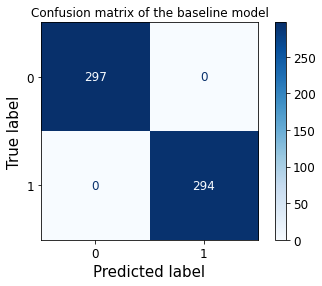

In [14]:
# Plot the confusion matrix of the baseline model
plt.figure(figsize=(8,8));
disp = ConfusionMatrixDisplay(confusion_matrix=np.asarray([[297,0],[0,294]]));
disp = disp.plot(cmap='Blues');
plt.title('Confusion matrix of the baseline model');

Our baseline model correctly predicts 294 out of 591 posts with a 49.7% accuracy, which is not a good accuracy score.

## Model Fit and Testing


To create models for our data, we will vectorize our X to create features that will be accepted by the model functions. We will be using TF-IDF (term frequency–inverse document frequency) Vectorizer, which has hyperparameters we can tune (e.g. maximum features). 

As we want to compare between different models which have their own hyperparameters, we will leverage on GridSearchCV to find the best combination of hyperparameters for a given model.

_Classifier Functions_

As we are interested in the impact of each feature (i.e. each word) on the final model, we will prefer to choose classifier models that specify coefficients to our features over classifiers such as RandomForest, KNearestNeighbors and DecisionTrees as these do not give us coefficients. However, we will still use KNearestNeighbors and RandomForest to ensure we have a good representation of a wide variety of models.


## Model Evaluation

To evaluate our models, we will take into account the CV score, train score, test score, as well as some classification metrics ROC-AUC score, specificity and sensitivity. 
  
To help us with this, we have created a few functions earlier to return these values and plot the ROC-AUC curve.

In [15]:
# Create a dataframe to track our models
model_tracker = pd.DataFrame(columns=['Model Name','GS Best Score','Train Score',
                                      'Test Score','ROC-AUC Score', 'Sensitivity','Specificity'])
# Check model tracker
# model_tracker

All the code for the various models below have been commented out to prevent accidental running, most of these models will take awhile to finish.

For tvec, lr:
Best score: 0.959
Train score: 0.983
Test score: 0.963
Best parameters: {'lr__C': 1.0, 'tvec__max_features': 1250, 'tvec__ngram_range': (1, 1)}

ROC-AUC Score: 0.993

True Negatives: 286
False Positives: 11
False Negatives: 11
True Positives: 283
Sensitivity (Positive Detection Rate): 0.963
Specificity (Negative Detection Rate): 0.963


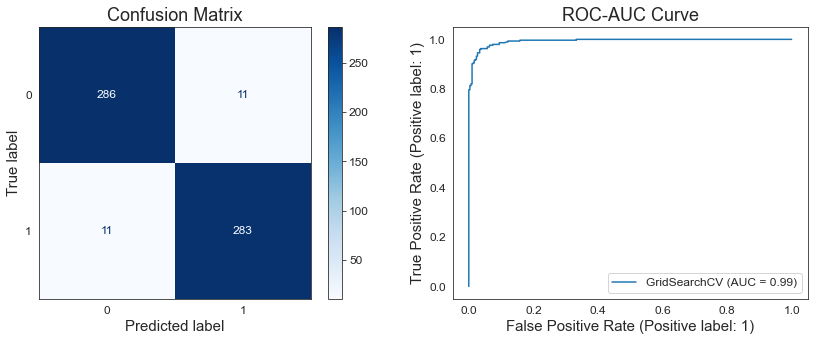

In [16]:
# Define dictionary for hyper-parameter tuning
gs_params = {
    'tvec__ngram_range': [(1,1), (1,2)],
    'tvec__max_features': [750,1000,1250],
    'lr__C': [0.5, 0.7, 1.0]
}

# Fit GridSearchCV and return model and metrics
tvec_lr, tvec_lr_metrics = model_tuning('tvec', TfidfVectorizer(),'lr', LogisticRegression(),gs_params,X_train,y_train,X_test,y_test)

# Plot confusion matrix and return additional metrics
tvec_lr_metrics.extend(model_eval(tvec_lr, X_test, y_test))

# Add metrics to model tracker
model_tracker.loc[len(model_tracker)] = tvec_lr_metrics

For tvec, nb:
Best score: 0.962
Train score: 0.977
Test score: 0.951
Best parameters: {'nb__alpha': 0.5, 'nb__fit_prior': True, 'tvec__max_features': 1250, 'tvec__ngram_range': (1, 1)}

ROC-AUC Score: 0.994

True Negatives: 274
False Positives: 23
False Negatives: 6
True Positives: 288
Sensitivity (Positive Detection Rate): 0.98
Specificity (Negative Detection Rate): 0.923


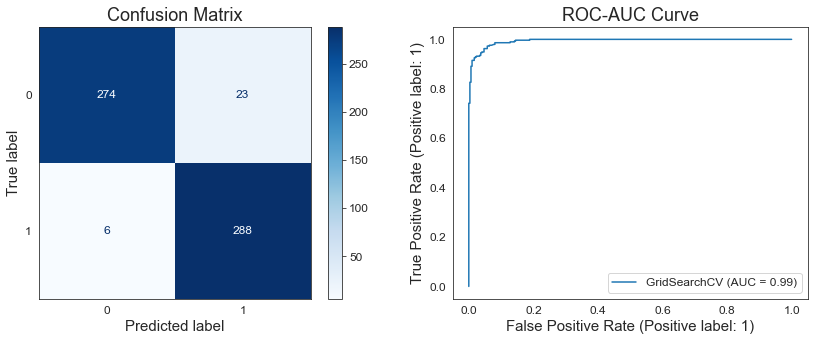

In [17]:
# Define dictionary for hyper-parameter tuning
gs_params = {
    'tvec__ngram_range': [(1,1), (1,2)],
    'tvec__max_features': [750,1000,1250],
    'nb__fit_prior': [True,False],
    'nb__alpha': [0.5,1.0]
}

# Fit GridSearchCV and return model and metrics
tvec_nb, tvec_nb_metrics = model_tuning('tvec', TfidfVectorizer(),'nb', MultinomialNB(),gs_params,X_train,y_train,X_test,y_test)

# Plot confusion matrix and return additionaol metrics
tvec_nb_metrics.extend(model_eval(tvec_nb, X_test, y_test))

# Add metrics to model tracker
model_tracker.loc[len(model_tracker)] = tvec_nb_metrics

For tvec, rfc:
Best score: 0.916
Train score: 0.93
Test score: 0.905
Best parameters: {'rfc__max_depth': 5, 'rfc__max_features': 'sqrt', 'rfc__n_estimators': 150, 'rfc__random_state': 6, 'tvec__max_features': 1250, 'tvec__ngram_range': (1, 2)}

ROC-AUC Score: 0.975

True Negatives: 285
False Positives: 12
False Negatives: 44
True Positives: 250
Sensitivity (Positive Detection Rate): 0.85
Specificity (Negative Detection Rate): 0.96


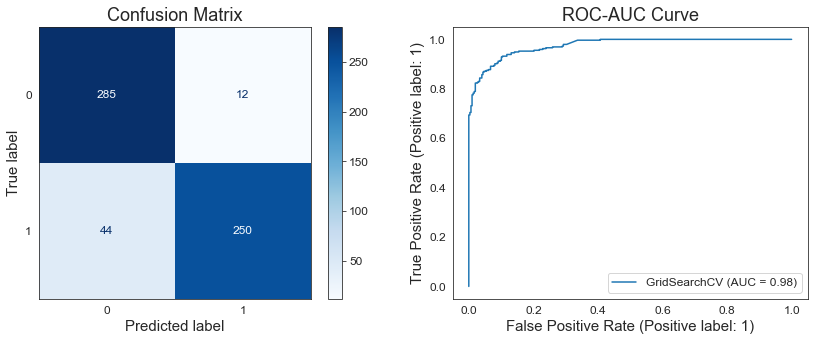

In [18]:
# Define dictionary for hyper-parameter tuning
gs_params = {
    'tvec__ngram_range': [(1,1), (1,2)],
    'tvec__max_features': [750,1000,1250],
    'rfc__n_estimators': [50,100,150],
    'rfc__max_depth': [1, 3, 5],
    'rfc__max_features': ['sqrt'],
    'rfc__random_state': [6]
}

# Fit GridSearchCV and return model and metrics
tvec_rfc, tvec_rfc_metrics = model_tuning('tvec', TfidfVectorizer(),'rfc', RandomForestClassifier(),gs_params,X_train,y_train,X_test,y_test)

# Plot confusion matrix and return additionaol metrics
tvec_rfc_metrics.extend(model_eval(tvec_rfc, X_test, y_test))

# Add metrics to model tracker
model_tracker.loc[len(model_tracker)] = tvec_rfc_metrics

For tvec, knn:
Best score: 0.914
Train score: 0.945
Test score: 0.895
Best parameters: {'knn__n_jobs': -1, 'knn__n_neighbors': 4, 'knn__p': 2, 'knn__weights': 'uniform', 'tvec__max_features': 1250, 'tvec__ngram_range': (1, 1)}

ROC-AUC Score: 0.953

True Negatives: 245
False Positives: 52
False Negatives: 10
True Positives: 284
Sensitivity (Positive Detection Rate): 0.966
Specificity (Negative Detection Rate): 0.825


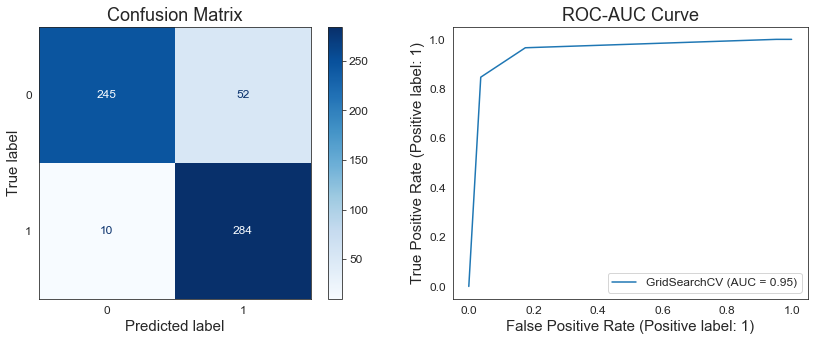

In [19]:
# Define dictionary for hyper-parameter tuning
gs_params = {
    'tvec__ngram_range': [(1,1), (1,2)],
    'tvec__max_features': [750,1000,1250],
    'knn__n_neighbors': [2,3,4,5],
    'knn__p': [1,2],
    'knn__n_jobs': [-1],
    'knn__weights': ['distance','uniform']
}

# Fit GridSearchCV and return model and metrics
tvec_knn, tvec_knn_metrics = model_tuning('tvec', TfidfVectorizer(),'knn', KNeighborsClassifier(),gs_params,X_train,y_train,X_test,y_test)

# Plot confusion matrix and return additionaol metrics
tvec_knn_metrics.extend(model_eval(tvec_knn, X_test, y_test))

# Add metrics to model tracker
model_tracker.loc[len(model_tracker)] = tvec_knn_metrics

In [20]:
#Showing our scores based on the 4 models trained so far
model_tracker

,Model Name,GS Best Score,Train Score,Test Score,ROC-AUC Score,Sensitivity,Specificity
0,tvec_lr,0.959,0.983,0.963,0.993,0.963,0.963
1,tvec_nb,0.962,0.977,0.951,0.994,0.980,0.923
2,tvec_rfc,0.916,0.930,0.905,0.975,0.850,0.960
3,tvec_knn,0.914,0.945,0.895,0.953,0.966,0.825


Firstly, all of our models trained handily did better as compared to our baseline model, which did not come as a surprise as our dataset is balanced. Our models across the board also seem to be slightly overfitting with slightly higher train scores compared to test scores.

The model with the highest accuracy is the **tvec_lr** classifier with a test score of 0.963, although the CV score through gridsearch is slightly higher for **tvec_nb** (0.962 versus 0.959).

Additionally, the model with the highest specificity score is **tvec_nb**, which gave us the lowest amount of false negatives

We can see that 3 of the 4 models have higher sensitivity scores compared against specificity with the exception of **tvec_rfc**. 

As we are most interested in the decreasing the number of false negatives of our classifier in predicting the subreddit a given post belongs to, we want to look at the models that have sensitivity scores. At this point, we would probably look to select the **tvec_nb** model.

Another benefit of selecting the tvec_nb model allows us to iterate in a more intuitive manner as we are able to see the impact of each feature (words) as it specifies coefficients to each word, and use such analyses to further improve our model.

## Model Iteration

Let's take a closer look at our misclassified data and the features that are the most important for the **tvec_lr** model.

In [21]:
# Create tvec for tvec_lr

tvec = TfidfVectorizer(max_features=1250, ngram_range = (1,1)) # Create tvec with best parameters for tvec_lr identified earlier

X_train_tvec = pd.DataFrame(tvec.fit_transform(X_train).toarray(),
                          columns = tvec.get_feature_names())
X_test_tvec = pd.DataFrame(tvec.transform(X_test).toarray(),
                          columns = tvec.get_feature_names())
X_tvec = pd.DataFrame(tvec.transform(X).toarray(),
                          columns = tvec.get_feature_names())

In [22]:
# Create lr instance with best parameters
tvec_nb_selected = MultinomialNB(alpha = 0.5, fit_prior = True)
tvec_nb_selected.fit(X_train_tvec,y_train)
importances = pd.DataFrame(data={
    'Attribute': X_train_tvec.columns,
    'Importance': tvec_nb_selected.coef_[0]
})
importances = importances.sort_values(by='Importance', ascending=False)

In [23]:
# 15 Most important words for predicting LifeAdvice Subreddit
importances.head(15)

# Click on the ... bubble to see words

,Attribute,Importance
399,feel,-4.606542
302,don,-4.704815
587,job,-4.747994
630,like,-4.753863
1198,want,-4.785959
1230,work,-4.865938
600,know,-4.902430
1243,year,-4.954139
438,friend,-4.963301
1122,time,-5.004050


In [24]:
# 15 Most important words for predicting Fanfiction Subreddit
importances.tail(15)

# Click on the ... bubble to see words

,Attribute,Importance
385,fandom,-9.170117
73,author,-9.170117
72,au,-9.170117
505,harry,-9.170117
1204,wattpad,-9.170117
350,et,-9.170117
1019,smut,-9.170117
521,hero,-9.170117
869,que,-9.170117
552,il,-9.170117


In [25]:
# Get the most important words into lists
most_impt_feats_pos = importances.head(15)['Attribute'].values
most_impt_feats_neg = importances.tail(15)['Attribute'].values

# Combining both lists
most_impt_feats = most_impt_feats_pos + most_impt_feats_neg

In [26]:
# Checks words from positive class against words in negative class and stores them in variable if any
most_impt_feats_overlap = [w for w in most_impt_feats_pos if w in most_impt_feats_neg]

In [27]:
most_impt_feats_overlap

[]

It seems we do not have any overlapping words, which is very good as it shows that each subreddit have it's own unique vocabulary.

To analyse the misclassfied data, we will add the 'all_text' and 'all_text_cleaned' into one dataframe.

In [28]:
#Create dataframe and add actual y values
all_model_predictions = pd.DataFrame()
all_model_predictions['actual_subreddit'] = y
all_model_predictions['predicted_subreddit'] = tvec_nb_selected.predict(X_tvec)
all_model_predictions['raw_post'] = master_df['all_text']
all_model_predictions['cleaned_post'] = master_df['all_text_cleaned']
all_model_predictions['misclassified'] = np.where(all_model_predictions['actual_subreddit'] != all_model_predictions['predicted_subreddit'], 1, 0)
all_model_predictions.loc[(all_model_predictions['misclassified'] == 1) & (all_model_predictions['actual_subreddit'] == 1), :].head(10)

# Click on the ... bubble to see misclassified posts

,actual_subreddit,predicted_subreddit,raw_post,cleaned_post,misclassified
1039,1,0,How to find a cash piggy [removed],find cash piggy remove,1
1046,1,0,How do I get any sense of direction in life? [removed],sense direction remove,1
1127,1,0,WE NEED YOUR HELP [removed],need help remove,1
1153,1,0,How do I tell my mentor I don't care about a particular style. For context I am an apprentice at a Tattoo studio in the city I live in. My Mentor has been having me take on almost every project th...,tell mentor don t care particular style context apprentice tattoo studio city live mentor have project gets throw way regardless feeling need experience fund project currently huge clientele come ...,1
1310,1,0,Saw this and thought it belonged here. Please help this person out on their post. [removed],see think belong help person post remove,1
1324,1,0,What songs have you helped you with depression?,song help depression,1
1335,1,0,Can people change? Like not from any type of hand trauma or anything like that. Do people actually change or like do they just learn that's not going to be a good out come? \n\nAny other studies o...,people change like type hand trauma like people actually change like learn s go good come study thread link welcome,1
1427,1,0,I (18m) have been going out with a (23f) woman. Is this weird?,m go f woman weird,1
1453,1,0,"Finding good advice Wondering if anyone can point me to some good advice posts, comments that they found interesting and aspiring",find good wonder point good post comment find interesting aspiring,1
1492,1,0,"My discord chat server was recently raided while I was asleep &amp;#x200B;\n\nHello, my server was recently raided wherein someone spammed gore and pinged a bunch of people that were online. I'm t...",discord chat server recently raid asleep x b hello server recently raid spamme gore ping bunch people online m admin server ve member user join week ago link think like write announcement apologiz...,1


We want to see which words are the most common in our misclassified lists

In [29]:
# List of misclassified LifeAdvice posts
misclassed_la = all_model_predictions.loc[(all_model_predictions['misclassified'] == 1) 
                                            & (all_model_predictions['actual_subreddit'] == 1), :]['cleaned_post'].tolist()
# Find counts of words in misclassified posts
misclassed_la_string = " ".join(misclassed_la)
misclassed_la_words = misclassed_la_string.split()
misclassed_la_counts = Counter(misclassed_la_words)

# Show words with the highest wordcount
misclassed_la_df = pd.DataFrame.from_dict(misclassed_la_counts,orient = 'index',columns=['wordcount'])
misclassed_la_df.sort_values(by='wordcount',ascending=False).head(15)
# Click on the ... bubble to see words

,wordcount
m,13
style,11
like,10
good,10
t,10
know,8
don,8
remove,7
think,7
happen,6


In [30]:
# List of misclassified Fanfic posts

misclassed_ff = all_model_predictions.loc[(all_model_predictions['misclassified'] == 1) 
                                            & (all_model_predictions['actual_subreddit'] == 0), :]['cleaned_post'].tolist()
# Find counts of words in misclassified posts
misclassed_ff_string = " ".join(misclassed_ff)
misclassed_ff_words = misclassed_ff_string.split()
misclassed_ff_counts = Counter(misclassed_ff_words)

# Show words with the highest wordcount
misclassed_ff_df = pd.DataFrame.from_dict(misclassed_ff_counts,orient = 'index',columns=['wordcount'])
misclassed_ff_df.sort_values(by='wordcount',ascending=False).head(15)
# Click on the ... bubble to see words

,wordcount
s,60
t,58
cock,39
know,27
like,27
m,25
find,23
want,22
time,21
head,20


To improve our model, we will try to add in more stopwords using the words that appear most in the misclassified posts, but we want to make sure that we are not removing words from the most important features.

In [31]:
new_stopwords = misclassed_la_df[misclassed_la_df['wordcount'] > 5].index.tolist()
new_stopwords.extend(misclassed_ff_df[misclassed_ff_df['wordcount'] > 20].index.tolist())

In [32]:
new_stopwords = [w for w in new_stopwords if w not in most_impt_feats]

In [33]:
# Create new TF-IDF with new stopwords
tvec_n = TfidfVectorizer(max_features=1250, ngram_range = (1,1), stop_words=new_stopwords) # Add in new stop words

X_train_tvec_new = pd.DataFrame(tvec_n.fit_transform(X_train).toarray(),
                          columns = tvec_n.get_feature_names())
X_test_tvec_new = pd.DataFrame(tvec_n.transform(X_test).toarray(),
                          columns = tvec_n.get_feature_names())
X_tvec_new = pd.DataFrame(tvec_n.transform(X).toarray(),
                          columns = tvec_n.get_feature_names())

In [34]:
# Create new lr model
tvec_nb_new = MultinomialNB(alpha = 0.5, fit_prior = True)
tvec_nb_new.fit(X_train_tvec_new,y_train)
tvec_nb_new.score(X_test_tvec_new,y_test)

0.9526226734348562

ROC-AUC Score: 0.994

True Negatives: 273
False Positives: 24
False Negatives: 4
True Positives: 290
Sensitivity (Positive Detection Rate): 0.986
Specificity (Negative Detection Rate): 0.919


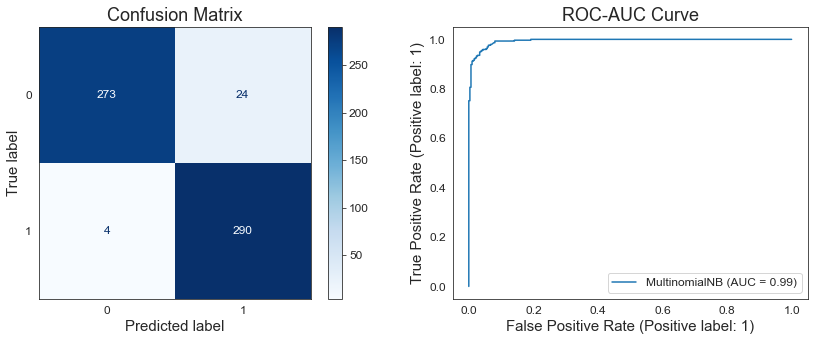

In [35]:
# Get new metrics
tvec_nb_new_metrics = ['tvec_lr_new','NA',tvec_nb_new.score(X_train_tvec_new,y_train),tvec_nb_new.score(X_test_tvec_new,y_test)]
# Plot confusion matrix, ROC-AUC curve and get more metrics
tvec_nb_new_metrics.extend(model_eval(tvec_nb_new, X_test_tvec_new,y_test))

In [36]:
# Add to model tracker
model_tracker.loc[len(model_tracker)] = tvec_nb_new_metrics
model_tracker

,Model Name,GS Best Score,Train Score,Test Score,ROC-AUC Score,Sensitivity,Specificity
0,tvec_lr,0.959,0.983000,0.963000,0.993,0.963,0.963
1,tvec_nb,0.962,0.977000,0.951000,0.994,0.980,0.923
2,tvec_rfc,0.916,0.930000,0.905000,0.975,0.850,0.960
3,tvec_knn,0.914,0.945000,0.895000,0.953,0.966,0.825
4,tvec_lr_new,NA,0.976744,0.952623,0.994,0.986,0.919


Removing some stopwords has actually worked and improved our test and sensitivity, which meant that by nature of reducing false negatives we increased our total number of true positives.

Our model is overfitting less compared to before implementing the new stopwords.

## Model Interpretation

Looking closer at the model, we'll want to look at the features that are the most important for both classes.

In [37]:
most_impt_feats_overlap

[]

In [38]:
# 15 Most important words for predicting LifeAdvice Subreddit
for word in most_impt_feats_pos:
    print(word)
# Click on the ... bubble to see words

feel
don
job
like
want
work
know
year
friend
time
ve
thing
school
go
live


In [39]:
# 15 Most important words for predicting Fanfiction Subreddit
for word in most_impt_feats_neg:
    print(word)
# Click on the ... bubble to see words

fandom
author
au
harry
wattpad
et
smut
hero
que
il
protagonist
prompt
dialogue
je
trope


What seems to differentiate the posts between FanFiction and LifeAdvice?

**FanFiction**

It seems that posts from the FanFiction subreddit tend to revolve around the writing process with words like 'story','character','reader','author','chapter'. My initial feeling of the FanFiction subreddit is that of a community where people share their 'fanfics' for feedback and look for inspiration to write their own fiction stories. However, it is evident that the subreddit is more commonly used for hobbyist or aspiring writers to find out more on the writing process. Looking into the subreddit further, it seems that posting of 'fanfics' or promoting of oneself's writing is actually forbidden unless a weekly/ monthly prompt is given for redditors to respond with comments of their own writing.

**LifeAdvice**

Posts from LifeAdvice tend to resolve around issues, we can clearly group certain words into various types of issues people face:  

- Education and Jobs ('job','school','study')
- Relationships ('friend','family','parent')
- Financial ('money','pay')

The fact that we were able to group words into themes/topics was very insightful as we have the potential to further explore a post given  it seeking advice, what kind of advice is being seeked? Can we build a model that is able to classify posts into various topics?   

[**Multi-class classification**](https://en.wikipedia.org/wiki/Multiclass_classification)

Ultimately, it is hard to definitively say that any one feature is very important, over the others, as our model is based on the interaction of many, many features (words) to provide us with context. As such looking at words in isolation tend to not provide us with useful information.

## Conclusions & Recommendations

Let's revisit our problem statement once more:

**Problem Statement**

We seek to classify which subreddit a post belongs to in a bid to understand if there are any differences in posts of a fictitious nature against one of a non-ficticious nature.  

- To understand words which belong in the vocabulary of fiction/ non-fiction

- To understand words which describe issues that people are seeking advice for

Based on our analyses and the data science process, we managed to come up with a model that accurately predicts around 96% of posts' subreddit. Here are some of our findings:

- **Vocabulary Differences:** Posts which are fictional/ non-fictional nature tend to have different vocabulary. Fictional posts tend to stretch the truth while posts that are non-fiction tend to report the truth.

- **Reddit a good source of reference as book excerpts?** Most reddit posts tend to be written in first person as most ports are personal recounts of experiences. Books on the other hand tend be written in the second or third person perspective as it allows authors to write from a broader perspective. Reddit posts also tend to have many spelling/ grammar errors which is not the case of published books which are proof-read multiple times before publishing.

## Considering Limitations

As with every dataset and project, there are limitations we need to consider:

**Data Collection**:   
- Context provided by posts from Reddits tends to be more U.S. centric, so these themes and language may only be applicable to the U.S. Additionally, we'll need to remember that U.S Reddit users are only a subset of the U.S that is also not representative of Singapore country's preferences and demographic.
- For the purposes of this project, we managed to collect a balanced dataset, keeping in mind our problem statement, there is a very high chacne that new data (documents/books/text) will not be balanced. We may have to adapt our model/ evaluation metrics to be better able to anticipate changes in class balances or be unaffected by class balances.
- As we only scraped approximately 1000 posts per subreddit, I believe our model could be more accurate if we increase the number of posts in our training dataset so that the model can learn more through existing data.

**Feature Engineering**:

- Majority of our feature engineering/transformation came from tokenizing and vectorizing texts. While we created some numerical features relating to the texts like word_count, character_lengths we did not use these feature in our model. Moving forward, we explore more numerical features like avg_sentence_length/avg_word_length make our model more robust.

**Modelling**

- Building on the earlier point made data collection, we were able to collect our data in a balanced manner. Very likely in a production environment, we would have little control over the balanceness of our data. In the context of the library, we will probably have to classify whatever comes to hand be it a new book which the library acquired or an existing one which was returned by a reader. In cases of imbalanced data like this, is our current model able to cope with unbalanced data? How will it affect our evlauation metrics?

- Furthermore, we may also want to explore expanding our model to serve more problem statements. We can consider making a model with more 'depth', in the case of non-fiction books, can we train another model which can classify non-fiction books into sub-genres of non-fiction? Another way wse can consider moving forward is expanding the 'breadth' of the model, are we able to create a model which is able to classify more than 2 genres? What are the considerations as well as evaluation metrics do we have to conside for such a model?

In [40]:
#Saving our scores to a .csv file
model_tracker.to_csv('../datasets/model_score_tracking.csv',index=False)

--- End of Notebook ---

---